**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [40]:
# Write your code here
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize, fsolve
import matplotlib.pyplot as plt

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [41]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [42]:
# write you answer here
# generate the linspace
data_check = np.linspace(0.1,2.0,10)

# set omega as numeraire
omega = 1


# define optimal behavior for firm 1 and 2
def l_1(p_1):
    return ((p_1 * par.A * par.gamma)/(omega))**(1/(1 - par.gamma))

def l_2(p_2):
    return ((p_2 * par.A * par.gamma)/(omega))**(1/(1 - par.gamma))

# define optimal production
def y_1(p_1):
    return par.A * (l_1(p_1))**(par.gamma)

def y_2(p_2):
    return par.A * (l_2(p_2))**(par.gamma)

# define implied profits
def pi_1(p_1): 
    return (1 - par.gamma)/(par.gamma) * omega * l_1(p_1) 

def pi_2(p_2): 
    return (1 - par.gamma)/(par.gamma) * omega * l_2(p_2) 

# define optimal consumption as a function of a given l
def c_1(l, p_1, p_2):
    return par.alpha * (omega * l + par.T + pi_1(p_1) + pi_2(p_2)) / p_1

def c_2(l, p_1, p_2):
    return (1 - par.alpha) * (omega * l + par.T + pi_1(p_1) + pi_2(p_2)) / (p_2 + par.tau)

# define optimal l as the value for l that exhibits optimal behavior
def objective_function(l, p_1, p_2):
    # Ensure l is a positive value
    l = l[0]
    if l <= 0:
        return np.inf
    term1 = np.log((c_1(l, p_1, p_2)) ** par.alpha * (c_2(l, p_1, p_2)) ** (1 - par.alpha))
    term2 = par.nu * l ** (1 + par.epsilon) / (1 + par.epsilon)
    # change the sign to negative as we are maximizing, and the minimize library minimizes
    return -(term1 - term2)

# Define an initial guess for l
initial_guess = [0.2]

# Now, all needed variables are defined such that we can check whether the three market conditions are satisfied for some combination of p1 and p2 in data_check.
found_solution = False
for p1 in data_check:
    for p2 in data_check:
        # Perform the optimization
        result = minimize(objective_function, initial_guess, args=(p1, p2))

        # Extract the optimal value of l
        l_star = result.x[0]

        # define c1_star and c2_star
        c1_star = c_1(l_star, p1, p2)
        c2_star = c_2(l_star, p1, p2)

        if np.isclose(c1_star, y_1(p1), atol=1e-01) and np.isclose(c2_star, y_2(p2), atol=1e-01) and np.isclose(l_1(p1) + l_2(p2), l_star, atol=1e-01):
            p1_solution = p1
            p2_solution = p2
            print(f"Found solution: p1 = {p1_solution:.3f}, p2 = {p2_solution:.3f}")
            found_solution = True
            break
    if found_solution:
        break

if not found_solution:
    print("No solution found in the provided data_check range.")

Found solution: p1 = 0.944, p2 = 1.578


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We find that there exist combinations of prices in the proposed range such that all three market clearings are satisfied. 
    <li> We find a higher price for p2 than for p1. The intuition is that alpha = 0.3, hence the consumers weight good 1 relative less than good 2. Thus, demand of good 2 is higher which contributes to higher prices in equilibrium of good 2. 
</span>


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [43]:
# Set omega as numeraire
omega = 1

# Define a function to solve for the equilibrium
def solve_equilibrium(p):
    p_1, p_2 = p
    # Perform the optimization to find l_star
    initial_guess = [0.2]
    result = minimize(objective_function, initial_guess, args=(p_1, p_2))
    l_star_value = result.x[0]

    # Define c1_star and c2_star
    c1_star_value = c_1(l_star_value, p_1, p_2)
    c2_star_value = c_2(l_star_value, p_1, p_2)

    # Market clearing conditions
    y1_star_value = y_1(p_1)
    y2_star_value = y_2(p_2)
    l1_star_value = l_1(p_1)
    l2_star_value = l_2(p_2)

    # Walras' law allows us to ignore one market condition, we use labor and one good market clearing
    labor_market = l_star_value - (l1_star_value + l2_star_value)
    good_market_1 = c1_star_value - y1_star_value
    # good_market_2 = c2_star_value - y2_star_value

    return [labor_market, good_market_1]

# Use fsolve to find the equilibrium prices
initial_guess_prices = [1.0, 1.0]
equilibrium_prices = fsolve(solve_equilibrium, initial_guess_prices)

p1_solution, p2_solution = equilibrium_prices

print(f"Found equilibrium prices: p1 = {p1_solution:.3f}, p2 = {p2_solution:.3f}")

# Check the market conditions with the found prices
result = minimize(objective_function, [0.2], args=(p1_solution, p2_solution))
l_star_value = result.x[0]

c1_star_value = c_1(l_star_value, p1_solution, p2_solution)
c2_star_value = c_2(l_star_value, p1_solution, p2_solution)

y1_star_value = y_1(p1_solution)
y2_star_value = y_2(p2_solution)
l1_star_value = l_1(p1_solution)
l2_star_value = l_2(p2_solution)

print(f"Market conditions with equilibrium prices:")
print(f"Deviation of clearance on labor market: {l_star_value - (l1_star_value + l2_star_value):.3f}")
print(f"Deviation of clearance on good market 1: {c1_star_value - y1_star_value:.3f}")
print(f"Deviation of clearance of good market 2: {c2_star_value - y2_star_value:.3f}")

Found equilibrium prices: p1 = 0.976, p2 = 1.491
Market conditions with equilibrium prices:
Deviation of clearance on labor market: -0.000
Deviation of clearance on good market 1: -0.000
Deviation of clearance of good market 2: -0.000


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We find that the prices p1 = 0.976 and p2 = 1.491 clear the markets.
    <li> As this is an analytical solution, there is a slight deviation of the market clearance. However, this is so small that it essentially is meaninless. 
</span>


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

To solve the question, we need to be very careful of some mechanism within the model that out defined functions need to be able to incorporate. First of all, we need to ensure that the model continuously take into account that the government runs a balanced budget and hence has T = tau * y_2. 

Thus, we set up a function that takes p2 as an argument and returns the value for T that satisfies the gorvernment's budget constraint - given tau and p2. 

Following this, we can define the achieved utility of the consumer. To incorporate optimal choice of consumers, we only evaluate the utility function at optimal consumption- and labor levels, c1_star, c2_star and l_star. 

When we have done this, we make a 'double-loop', iterating through all possible combinations of p1 and p2 within our specified range. We acknowledge that this method may not be the smartest as it requires much computer power while also restricting the range of solutions quite heavily.

Given these combinations of p1 and p2, we set up a maximizing problem of the social-welfare-function, which we have defined. We are very cautious with this, as any change in tau also should lead to changes in consumers' choices. 
Then, given this reaction of consumers, we maximize the SWF wrt. tau while ensuring that the combination of tau and prices satisfy all three market clearing conditions. 

In [44]:
import numpy as np
from scipy.optimize import minimize

omega = 1

# Define optimal behavior for firm 1 and 2
def l_1(p1):
    return ((p1 * par.A * par.gamma) / omega) ** (1 / (1 - par.gamma))

def l_2(p2):
    return ((p2 * par.A * par.gamma) / omega) ** (1 / (1 - par.gamma))

# Define optimal production
def y_1(p1):
    return par.A * (l_1(p1)) ** par.gamma

def y_2(p2):
    return par.A * (l_2(p2)) ** par.gamma

# Define the function to update par.T
def updated_T(p2):
    par.T = par.tau * y_2(p2)

# Define implied profits
def pi_1(p1):
    return (1 - par.gamma) / par.gamma * omega * l_1(p1)

def pi_2(p2):
    return (1 - par.gamma) / par.gamma * omega * l_2(p2)

# Define optimal consumption as a function of a given l
def c_1(l, p1, p2):
    return par.alpha * (omega * l + par.T + pi_1(p1) + pi_2(p2)) / p1

def c_2(l, p1, p2):
    return (1 - par.alpha) * (omega * l + par.T + pi_1(p1) + pi_2(p2)) / (p2 + par.tau)

# Define the utility function
def utility(c1, c2, l):
    return par.alpha * np.log(c1) + (1 - par.alpha) * np.log(c2) - par.nu * (l ** (1 + par.epsilon)) / (1 + par.epsilon)

# Define the social welfare function
def SWF(c1, c2, l, p2):
    return utility(c1, c2, l) - par.kappa * y_2(p2)

# Define the objective function for optimizing labor
def objective_function(l, p1, p2):
    l = l[0]
    if l <= 0:
        return np.inf
    c1 = c_1(l, p1, p2)
    c2 = c_2(l, p1, p2)
    term1 = np.log(c1 * par.alpha * c2 * (1 - par.alpha))
    term2 = par.nu * l ** (1 + par.epsilon) / (1 + par.epsilon)
    return -(term1 - term2)

# Define the objective function for optimizing tau
def tau_objective_function(tau, p1, p2):
    par.tau = tau
    updated_T(p2)
    result = minimize(objective_function, [0.2], args=(p1, p2), method='SLSQP', options={'disp': False})
    if not result.success:
        print(f"Labor optimization failed for tau = {tau:.3f}, p1 = {p1:.3f}, p2 = {p2:.3f}")
        return np.inf
    l_star = result.x[0]
    c1_star = c_1(l_star, p1, p2)
    c2_star = c_2(l_star, p1, p2)
    return -SWF(c1_star, c2_star, l_star, p2)

# Generate the linspace
data_check = np.linspace(0.1, 2.0, 150)

# Now, all needed variables are defined such that we can check whether the three market conditions are satisfied for some combination of p1 and p2 in data_check.
found_solution = False
for p1 in data_check:
    for p2 in data_check:
        # Find the optimal tau
        result_tau = minimize(tau_objective_function, [0.1], args=(p1, p2), bounds=[(0, 1)], method='SLSQP', options={'disp': True})
        if not result_tau.success:
            print(f"Tau optimization failed for p1 = {p1:.3f}, p2 = {p2:.3f}")
            continue
        optimal_tau = result_tau.x[0]
        par.tau = optimal_tau
        updated_T(p2)
        
        # Perform the optimization for labor with the optimal tau
        result = minimize(objective_function, [0.2], args=(p1, p2), method='SLSQP', options={'disp': False})
        
        if result.success:
            # Extract the optimal value of l
            l_star = result.x[0]

            # Define c1_star and c2_star
            c1_star = c_1(l_star, p1, p2)
            c2_star = c_2(l_star, p1, p2)

            # Calculate social welfare at these prices etc.
            social_welfare = SWF(c1_star, c2_star, l_star, p2)

            print(f"Checking conditions for p1 = {p1:.3f}, p2 = {p2:.3f}, tau = {optimal_tau:.3f}")
            print(f"c1_star = {c1_star:.3f}, y_1(p1) = {y_1(p1):.3f}")
            print(f"c2_star = {c2_star:.3f}, y_2(p2) = {y_2(p2):.3f}")
            print(f"l_star = {l_star:.3f}, l_1(p1) + l_2(p2) = {l_1(p1) + l_2(p2):.3f}")

            if np.isclose(c1_star, y_1(p1), atol=1e-01) and np.isclose(c2_star, y_2(p2), atol=1e-01) and np.isclose(l_1(p1) + l_2(p2), l_star, atol=1e-01):
                p1_solution = p1
                p2_solution = p2
                print(f"Found solution: p1 = {p1_solution:.3f}, p2 = {p2_solution:.3f}, tau = {optimal_tau:.3f},T={optimal_tau*y_2(p2_solution):.3f}")
                found_solution = True
                break
            else:
                print(f"Market conditions not satisfied for p1 = {p1:.3f}, p2 = {p2:.3f}, tau = {optimal_tau:.3f}")
                print(f"c1_star = {c1_star:.3f}, y_1(p1) = {y_1(p1):.3f}")
                print(f"c2_star = {c2_star:.3f}, y_2(p2) = {y_2(p2):.3f}")
                print(f"l_star = {l_star:.3f}, l_1(p1) + l_2(p2) = {l_1(p1) + l_2(p2):.3f}")
        else:
            print(f"Labor optimization failed for p1 = {p1:.3f}, p2 = {p2:.3f}")
    if found_solution:
        break

if not found_solution:
    print("No solution found in the provided data_check range.")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2563581251779292
            Iterations: 2
            Function evaluations: 4
            Gradient evaluations: 2
Checking conditions for p1 = 0.100, p2 = 0.100, tau = 0.000
c1_star = 3.790, y_1(p1) = 0.050
c2_star = 8.843, y_2(p2) = 0.050
l_star = 1.258, l_1(p1) + l_2(p2) = 0.005
Market conditions not satisfied for p1 = 0.100, p2 = 0.100, tau = 0.000
c1_star = 3.790, y_1(p1) = 0.050
c2_star = 8.843, y_2(p2) = 0.050
l_star = 1.258, l_1(p1) + l_2(p2) = 0.005
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.172423951281838
            Iterations: 2
            Function evaluations: 4
            Gradient evaluations: 2
Checking conditions for p1 = 0.100, p2 = 0.113, tau = 0.000
c1_star = 3.791, y_1(p1) = 0.050
c2_star = 7.846, y_2(p2) = 0.056
l_star = 1.258, l_1(p1) + l_2(p2) = 0.006
Market conditions not satisfied for p1 = 0.100, p2 = 0.113, tau = 0.0

<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We find that the prices p1 = 0.891 and p2 = 1.439 clear the markets. 
    <li> Given these prices, the tax tau = 0.100 (impying T = 0.072) is optimal for a social planner to maximize social welfare
    <li> We find that the tax is equal to the externality (kappa). This is intuitive, as this ensures that the external costs of consumption of the good are 'answered' by a corresponding increase in cost. Hence, this should lead consumers to take the full cost of the externality into account when choosing their consumption, leading to social-optimal-outcome.  
</span>

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [45]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [46]:
# start by setting some random seed (this could be left out)
np.random.seed(1986)
# First, define the v-vector
v = np.array([1, 2, 3])

# set the number of simulations
K = 10000

# Simulate draws of epsilon for each career track
epsilon = np.random.normal(0, par.sigma, (K, len(v)))

# Calculate the expected utility for each career track as the sum of v and the simulated epsilon
expected_utility = v + np.mean(epsilon, axis=0)

# Calculate the average realized utility for each career track
realized_utility = v + epsilon
average_realized_utility = np.mean(realized_utility, axis=0)

# Print the results
for j in range(len(v)):
    print(f"For Career track {j+1}:")
    print(f"  Expected Utility: {expected_utility[j]:.3f}")
    print(f"  Average Realized Utility: {average_realized_utility[j]:.3f}")
    print()
    print()


For Career track 1:
  Expected Utility: 0.995
  Average Realized Utility: 0.995


For Career track 2:
  Expected Utility: 1.980
  Average Realized Utility: 1.980


For Career track 3:
  Expected Utility: 3.014
  Average Realized Utility: 3.014




<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li>Both the expected and average realized utility is close to the known value of v_j. </li>
    <li>The expected and realized utilities differ slightly since the average realized utility is a mean of both v and epsilon whereas the expected utility is computed as v plus the mean of the epsilons.
</span>


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

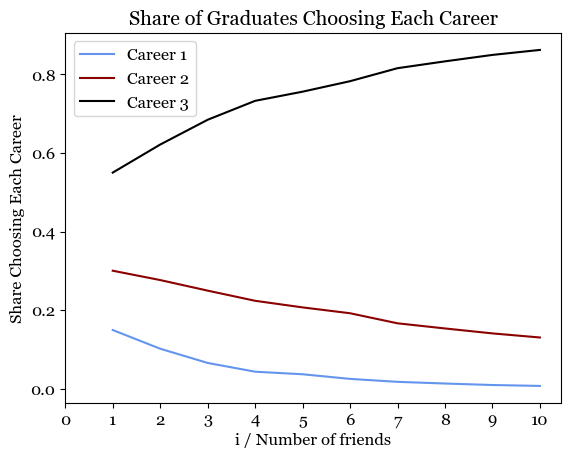

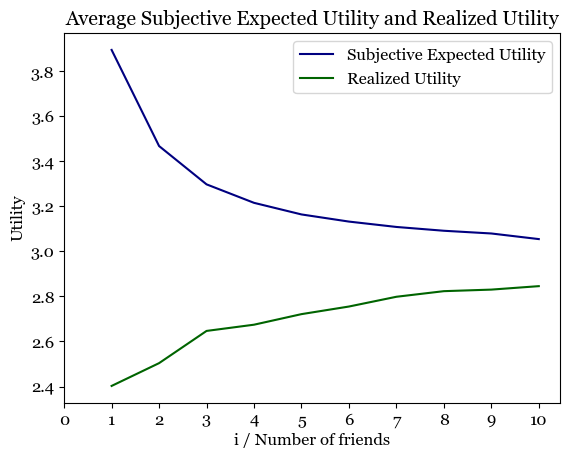

In [47]:
# set number of simulations
K = 10000
# set number of graduates
N = 10
# set number of career tracks
J = 3

# Initialize storage for results

# Start by creating an initial matrix of 0's that can be replaced based on conditions later on
career_choices = np.zeros((N, K), dtype=int)
subjective_expected_utilities = np.zeros((N, K))
realized_utilities = np.zeros((N, K))

# for each of the 10.000 simulations:
for k in range(K):
    for i in range(1, N+1):
        # define the number of friends:
        F_i = i
        
        # Draw J * F_i values of epsilon for the friends and store in a matrix:
        epsilon_friends = np.random.normal(0, par.sigma, (J, F_i))
        
        # Calculate prior expected utility for each career track (summing over each row, axis = 1, since rows display a career track)
        prior_expected_utility = v + np.mean(epsilon_friends, axis=1)
        
        # Draw J values of epsilon for the graduate:
        epsilon_own = np.random.normal(0, par.sigma, J)
        
        # Choose the career track with the highest expected utility:
        chosen_career = np.argmax(prior_expected_utility)
        
        # Store results in the career_choices matrix defined priorly:
        career_choices[i-1, k] = chosen_career # start at row i-1 since indexing starts at 0
        subjective_expected_utilities[i-1, k] = prior_expected_utility[chosen_career]
        realized_utilities[i-1, k] = v[chosen_career] + epsilon_own[chosen_career]

# Calculate shares of graduates choosing each career
career_shares = np.zeros((N, J))
for i in range(N):
    for j in range(J):
        career_shares[i, j] = np.mean(career_choices[i] == j)

# Calculate average subjective expected utility:
average_subjective_expected_utility = np.mean(subjective_expected_utilities, axis=1)

# Calculate average ex post realized utility:
average_realized_utility = np.mean(realized_utilities, axis=1)

# Visualization:
plt.rcParams['font.family'] = ['Georgia']
plt.rcParams['font.size'] = 12
colors = ["#6495ED", "#8B0000", "Black"]

for j in range(J):
    plt.plot(range(1, N+1), career_shares[:, j], label=f'Career {j+1}', color = colors[j])
plt.xlabel('i / Number of friends')
plt.ylabel('Share Choosing Each Career')
plt.title('Share of Graduates Choosing Each Career')
plt.xticks(range(0,11))
plt.legend()
plt.show()

plt.plot(range(1, N+1), average_subjective_expected_utility, label='Subjective Expected Utility', color = "Navy")
plt.plot(range(1, N+1), average_realized_utility, label='Realized Utility', color = "Darkgreen")
plt.xlabel('i / Number of friends')
plt.ylabel('Utility')
plt.xticks(range(0,11))
plt.title('Average Subjective Expected Utility and Realized Utility')
plt.legend()
plt.show()


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li>The more friends, the higher probability of choosing career 3 (and lower probability of choosing career 1 and 2 respectively). Intuition: Graduates choose the career with the highest prior expected utility. When you have more friends, you have more observations. Hence, this leads to a higher probability of the true 'best' career having the highest expected utility.</li>
    <li>When the number of friends increases, the expected utility and realized utilities get closer. This is essentially caused by the law of large numbers.</li>
</ol>
</span>


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

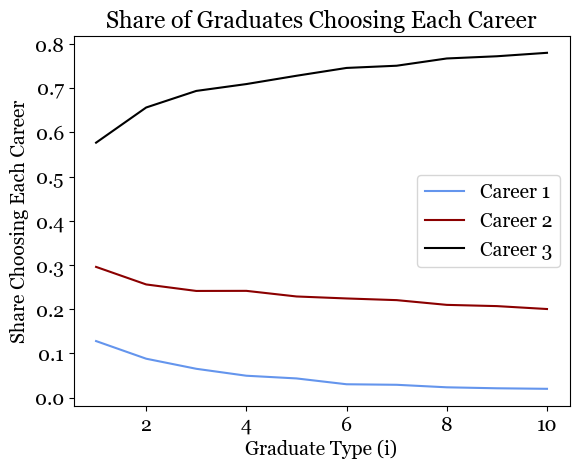

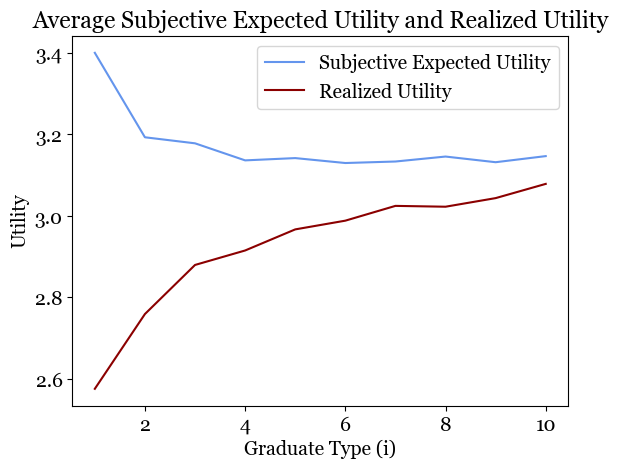

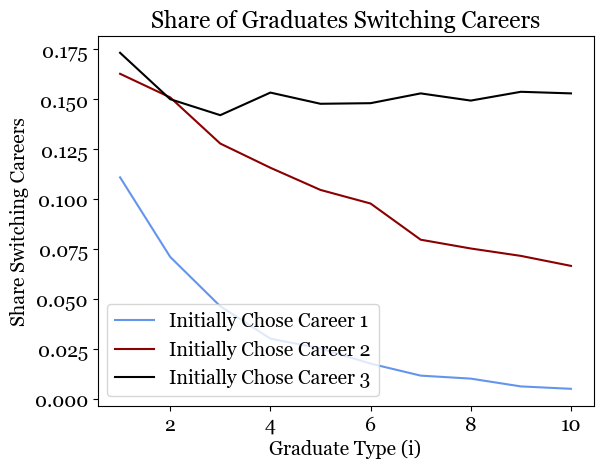

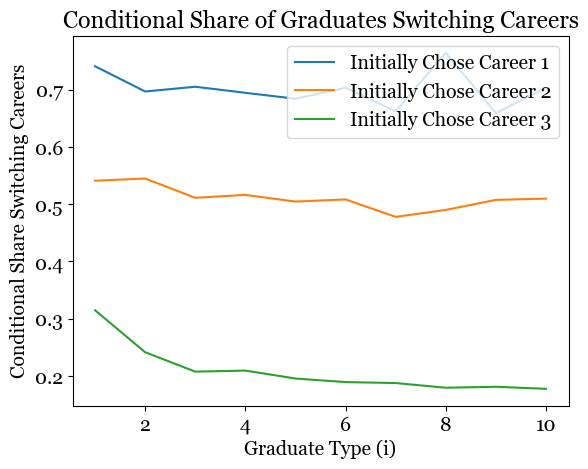

In [48]:
# define the switching cost
c = 1 

# Initialize storage for second year results
new_career_choices = np.zeros((N, K), dtype=int)
new_subjective_expected_utilities = np.zeros((N, K))
new_realized_utilities = np.zeros((N, K))
switching_decisions = np.zeros((N, K), dtype=bool)

# Simulate the process for the second year.
for k in range(K):
    for i in range(1, N+1):
        F_i = i
        initial_choice = career_choices[i-1, k]
        initial_realized_utility = realized_utilities[i-1, k]
        
        # Draw J * F_i values of epsilon for the friends again
        epsilon_friends = np.random.normal(0, par.sigma, (J, F_i))
        
        # Calculate prior expected utility for each career track
        prior_expected_utility = v + np.mean(epsilon_friends, axis=1)
        
        # Calculate new prior expected utility with switching cost
        new_prior_expected_utility = np.copy(prior_expected_utility)
        new_prior_expected_utility[initial_choice] = initial_realized_utility
        for j in range(J):
            if j != initial_choice:
                new_prior_expected_utility[j] -= c
        
        # Draw J values of epsilon for the graduate again
        epsilon_own = np.random.normal(0, par.sigma, J)
        
        # Calculate new realized utility with switching cost
        new_realized_utility = np.copy(v + epsilon_own)
        new_realized_utility -= c
        new_realized_utility[initial_choice] = initial_realized_utility
        
        # Choose the new career track with the highest expected utility
        new_chosen_career = np.argmax(new_prior_expected_utility)
        
        # Store results for the second year
        new_career_choices[i-1, k] = new_chosen_career
        new_subjective_expected_utilities[i-1, k] = new_prior_expected_utility[new_chosen_career]
        new_realized_utilities[i-1, k] = new_realized_utility[new_chosen_career]
        switching_decisions[i-1, k] = (new_chosen_career != initial_choice)

# Calculate shares of graduates choosing each career and switching decisions
career_shares = np.zeros((N, J))
switching_shares = np.zeros((N, J))

for i in range(N):
    for j in range(J):
        career_shares[i, j] = np.mean(new_career_choices[i] == j)
        switching_shares[i, j] = np.mean((career_choices[i] == j) & (switching_decisions[i]))

# Calculate average subjective expected utility
average_subjective_expected_utility = np.mean(new_subjective_expected_utilities, axis=1)

# Calculate average ex post realized utility
average_realized_utility = np.mean(new_realized_utilities, axis=1)

conditional_switching_shares = np.zeros((N, J))

for i in range(N):
    for j in range(J):
        # Calculate the share of graduates who initially chose career j and switched
        initially_chose_j = (career_choices[i] == j)
        if np.sum(initially_chose_j) > 0:
            conditional_switching_shares[i, j] = np.mean(switching_decisions[i, initially_chose_j])

# Set font to Georgia and font size to 14
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 14

# Visualization of career shares
for j in range(J):
    plt.plot(range(1, N+1), career_shares[:, j], label=f'Career {j+1}', color = colors[j])
plt.xlabel('Graduate Type (i)')
plt.ylabel('Share Choosing Each Career')
plt.title('Share of Graduates Choosing Each Career')
plt.legend()
plt.show()

# Visualization of average utilities
plt.plot(range(1, N+1), average_subjective_expected_utility, label='Subjective Expected Utility', color = colors[0])
plt.plot(range(1, N+1), average_realized_utility, label='Realized Utility', color = colors[1])
plt.xlabel('Graduate Type (i)')
plt.ylabel('Utility')
plt.title('Average Subjective Expected Utility and Realized Utility')
plt.legend()
plt.show()

# Visualization of switching shares
for j in range(J):
    plt.plot(range(1, N+1), switching_shares[:, j], label=f'Initially Chose Career {j+1}', color = colors[j])
plt.xlabel('Graduate Type (i)')
plt.ylabel('Share Switching Careers')
plt.title('Share of Graduates Switching Careers')
plt.legend()
plt.show()

# Visualization of conditional switching shares
for j in range(J):
    plt.plot(range(1, N+1), conditional_switching_shares[:, j], label=f'Initially Chose Career {j+1}')
plt.xlabel('Graduate Type (i)')
plt.ylabel('Conditional Share Switching Careers')
plt.title('Conditional Share of Graduates Switching Careers')
plt.legend()
plt.show()


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li>Still, more friends lead to a higher share choosing career 3. Same intuition as before.</li>
    <li>Comparing to the scenario before, a higher share of graduates chooses career 3 in the current scenario. The intuition is that graduates in the second year have better information and hence more accurate expectations.</li>
    <li>As a share of the total population, few people initially chose career 1 and switched to other careers. However, this does not take into account that a small share of the population initially did not choose career 1. Hence, we have constructed an additional figure. This shows that a high share of those who initially chose career 1 switch careers - and a small share of those who initially chose career 3 switch careers. The intuition is, once again, that their knowledge of the 'true' type of the career becomes greater after working there a year, hence people will be willing to switch from career 1 and not as likely to switch from career 3.</li>
</ol>
</span>


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [49]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

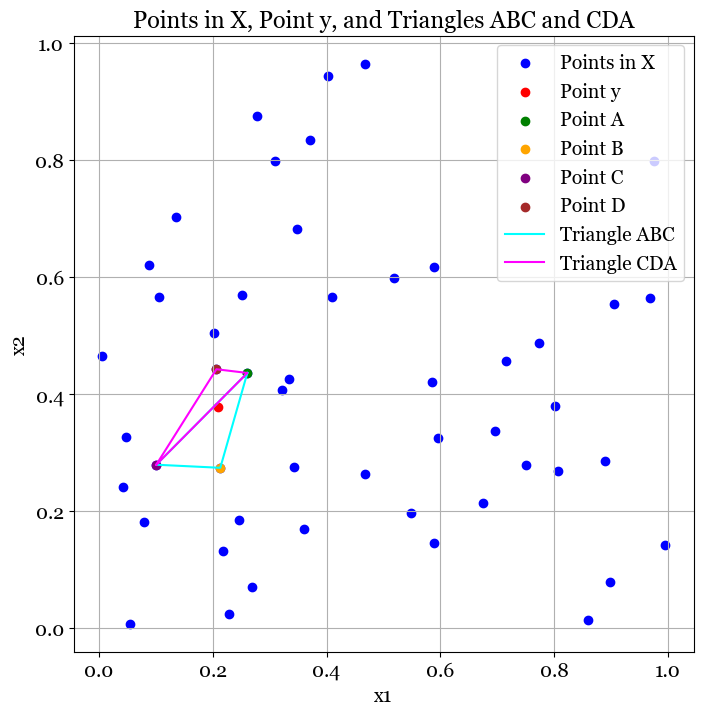

In [50]:
# First, we must illustrate X. X is defined as a set of coordinates, where x1 and x2 are drawn iid from a uniform distribution on [0,1].
# X is drawn from the code further up. Hence, we can simply plot X:
plt.figure(figsize=(8, 8))
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:, 0], X[:, 1], label='Points in X', color='blue')

# Then, plot y. y is also drawn further up, hence this can already be plotted.
plt.scatter(y[0], y[1], label='Point y', color='red')

# Then, find the points A, B, C and D. Notice that these points are defined as the least distance between points X and y given some condition.  
# Hence, define a distance-function and implement the condition later:
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


# Set up conditions for A, B, C, and D as specified in the description of the task
condition_A = lambda p, y: p[0] > y[0] and p[1] > y[1] 
condition_B = lambda p, y: p[0] > y[0] and p[1] < y[1]
condition_C = lambda p, y: p[0] < y[0] and p[1] < y[1]
condition_D = lambda p, y: p[0] < y[0] and p[1] > y[1]

def closest_points(X, y):
    A = min([p for p in X if condition_A(p, y)], key=lambda p: distance(p, y), default=None)
    B = min([p for p in X if condition_B(p, y)], key=lambda p: distance(p, y), default=None)
    C = min([p for p in X if condition_C(p, y)], key=lambda p: distance(p, y), default=None)
    D = min([p for p in X if condition_D(p, y)], key=lambda p: distance(p, y), default=None)
    return A, B, C, D

# store A, B a
A, B, C, D = closest_points(X, y)



# Plot points A, B, C, and D if they exist
if A is not None:
    plt.scatter(A[0], A[1], label='Point A', color='green')
if B is not None:
    plt.scatter(B[0], B[1], label='Point B', color='orange')
if C is not None:
    plt.scatter(C[0], C[1], label='Point C', color='purple')
if D is not None:
    plt.scatter(D[0], D[1], label='Point D', color='brown')

# Plot triangles ABC and CDA if points exist
if A is not None and B is not None and C is not None:
    plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], label='Triangle ABC', color='cyan')
if C is not None and D is not None and A is not None:
    plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], label='Triangle CDA', color='magenta')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Points in X, Point y, and Triangles ABC and CDA')
plt.legend()
plt.grid(True)
plt.show()


**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [51]:
# define the barycentric coordinates for triangle ABC
def barycentric_coordinates(y, A, B, C):
    denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denom
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denom
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Calculate barycentric coordinates for triangle ABC
r_ABC = barycentric_coordinates(y, A, B, C)

# Calculate barycentric coordinates for triangle CDA
r_CDA = barycentric_coordinates(y, C, D, A)

# Then, define a function that checks if they are inside the triangle 
def is_inside_triangle(r):
    return 0 <= r[0] <= 1 and 0 <= r[1] <= 1 and 0 <= r[2] <= 1

# print the output. First get the barycentric coodinates.
print(f'The barycentric coordinates of triangle ABC are {r_ABC[0]:.3f}, {r_ABC[1]:.3f}, {r_ABC[2]:.3f}')
print(f'The barycentric coordinates of triangle CDA are {r_CDA[0]:.3f}, {r_CDA[1]:.3f}, {r_CDA[2]:.3f}')

# then check whether y is inside the triangle
print(f'The point y is inside triangle ABC?: {is_inside_triangle(r_ABC)}')
print(f'The point y is inside triangle CBA?: {is_inside_triangle(r_CDA)}')

The barycentric coordinates of triangle ABC are 0.629, 0.069, 0.302
The barycentric coordinates of triangle CDA are 0.368, -0.134, 0.766
The point y is inside triangle ABC?: True
The point y is inside triangle CBA?: False


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We have computed the barycentric coordinates of y. 
    <li> Based on these, we find that y is inside triangle ABC but not inside triangle CBA. This aligns with our presented figure.
</ol>
</span>


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [52]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [53]:
# We seek to first compute the last steps of the algorithm. The function f is defined above. 
# first, evaluate the function at the respective corners, A, B, C and D.
fA = f(A)
fB = f(B)
fC = f(C)
fD = f(D)

# Then, check which triangle y is insidde using the code from before.
if is_inside_triangle(r_ABC):
    f_y_approx = r_ABC[0] * fA + r_ABC[1] * fB + r_ABC[2] * fC
    # Check if y is inside triangle CDA
elif is_inside_triangle(r_CDA):
    f_y_approx = r_CDA[0] * fC + r_CDA[1] * fD + r_CDA[2] * fA # approximate the f-function using the algorithm
else:
    f_y_approx = float('nan')

# compute the true value of f_y
f_y_true = f(y)

# output the true & approximated value, while also printing the error of computation:
print(f"Approximated value of f(y): {f_y_approx:.3f}")
print(f"True value of f(y): {f_y_true:.3f}")
print(f"Error: {abs(f_y_approx - f_y_true):.3f}")


Approximated value of f(y): 0.084
True value of f(y): 0.079
Error: 0.005


<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We have approximated the true value of f(y) very pricisely using the proposed algorithm.
</ol>
</span>


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [54]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [55]:
# We solve this question using the priorly defined functions of closest_points(X, y), barycentric_coordinates and inside_triangle. 

# Initiate an empty list for results:
results = []

# iterate over each element in the list Y
for y in Y:
    # store A, B, C and D as the closest points to y using the priorly defined function.
    A, B, C, D = closest_points(X, y)

    # set the approximation as nan if no closest point was found
    if A is None or B is None or C is None or D is None:
        f_y_approx = float('nan')
        f_y_true = f(y)
        error = float('nan')
    else:
        # Take out the barycentric coordinates for triangle ABC
        r_ABC = barycentric_coordinates(y, A, B, C)
        
        # Take out the barycentric coordinates for triangle CDA
        r_CDA = barycentric_coordinates(y, C, D, A)

        # Evaluate the function at points A, B, C, D to construct the approximated function-value:
        fA = f(A)
        fB = f(B)
        fC = f(C)
        fD = f(D)

        # Check if y is inside triangle ABC using the priorly defined function:
        if is_inside_triangle(r_ABC):
            f_y_approx = r_ABC[0] * fA + r_ABC[1] * fB + r_ABC[2] * fC
        # Check if y is inside triangle CDA
        elif is_inside_triangle(r_CDA):
            f_y_approx = r_CDA[0] * fC + r_CDA[1] * fD + r_CDA[2] * fA
        else:
            f_y_approx = float('nan')

        # Compute the true value of the function at y
        f_y_true = f(y)
        # compute the difference between the true value and the approximated value
        error = abs(f_y_approx - f_y_true) if not np.isnan(f_y_approx) else float('nan')
    # add the result to the result-list.
    results.append((y, f_y_approx, f_y_true, error))

# Print the results
for i, (y, f_y_approx, f_y_true, error) in enumerate(results):
    print(f"For the point y{i+1} = {y}")
    print(f"  Approximated value of f(y): {f_y_approx:.3f}")
    print(f"  True value of f(y): {f_y_true:.3f}")
    print(f"  Difference: {error:.3f}")
    # make spaces
    print()
    print()


For the point y1 = (0.2, 0.2)
  Approximated value of f(y): 0.040
  True value of f(y): 0.040
  Difference: 0.000


For the point y2 = (0.8, 0.2)
  Approximated value of f(y): 0.159
  True value of f(y): 0.160
  Difference: 0.001


For the point y3 = (0.8, 0.8)
  Approximated value of f(y): nan
  True value of f(y): 0.640
  Difference: nan


For the point y4 = (0.8, 0.2)
  Approximated value of f(y): 0.159
  True value of f(y): 0.160
  Difference: 0.001


For the point y5 = (0.5, 0.5)
  Approximated value of f(y): 0.251
  True value of f(y): 0.250
  Difference: 0.001




<span style="color: navy;">
<b>Conclusion:</b>
<ol>
    <li> We have approximated the function value of y for five elements in the list Y using properties of triangles and barycentric coordinates.
    <li> For four of these elements, we find - essentially - no difference in the approximation and the true value.
    <li> For one element (the third), the approximation is N/A. The reason is that we found no solution to the minimization problem using the closest_points()-function for this point. 
</ol>
</span>